In [35]:
# librerie utili
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [36]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [37]:
# configurazione
image_size = 224 # dimensione a cui ridimensionare ogni immagine
batch_size = 32  # batch size per i DataLoader
encoding_dim = 323 # componenti principali che spiegano l 75% della soglia
noise_std = 0.2
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test
epochs = 100 # epoche training, 100

pretty_labels = ['adenocarcinoma', 'benigno', 'carcinoma squamoso']  # nomi delle classi più leggibili

In [38]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
# percorso per salvare output
output_folder = os.path.join(base_dir, "ae_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
log_txt_path = os.path.join(output_folder, "classification_reports.txt")
save_path = os.path.join(output_folder, f'ae_data_{encoding_dim}_{noise_std}.pth')
experiment_name = os.path.splitext(os.path.basename(save_path))[0]

In [39]:
# caricamento dati
data_dict = torch.load(save_path, weights_only=False) # dati pre-elaborati (encoder) salvati in precedenza
X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

C:\Users\noemi\AppData\Local\Temp\ipykernel_19672\1939871260.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


In [40]:
# data_loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)


In [41]:
# modello flessibile
class FlexibleNet(nn.Module):  # rete neurale FC, configurabile (layer, dropout, batchnorm)
    def __init__(self, input_dim, hidden_dims, output_dim, use_batchnorm=False, dropout=0.0):
        super().__init__() # costruttore classe nn.Module 
        layers = [] # lista vuota per contenere layer rete neurale
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim)) # layer lineri
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim)) # batch normalization, opzionale
            layers.append(nn.ReLU()) # funzione di attivazione ReLu
            if dropout > 0:
                layers.append(nn.Dropout(dropout)) # dropout opzionale
            last_dim = hidden_dim # aggiornmento last_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers) # impacchettamento layer in un unico oggetto seguenziale

    def forward(self, x):
        return self.model(x)


In [42]:
# misura specificity, non ho trovato una funzione che lo fa di sklearn (come per f1, recall e precision)
def specificity_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    specificities = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities.append(specificity)

    if average == 'macro':
        return np.mean(specificities)
    elif average == 'none':
        return specificities
    else:
        raise ValueError("Inserire modalità")

In [43]:
# funzione di training
def train_model(model, train_loader, val_loader, criterion, optimizer, use_early_stopping=True, patience=5):
    best_val_loss = float('inf')  # inizializza la migliore loss di validazione
    trigger_times = 0             # contatore epoche
    history = {'train_acc': [], 'val_acc': []} # creazione liste accuracy

    for epoch in range(epochs): # loop di training per ogni epoca
        model.train()
        correct, total = 0, 0
        for X_batch, y_batch in train_loader: # loop su batch di input ed etchiette
            optimizer.zero_grad() # reset gradiente
            output = model(X_batch) # forward pass
            loss = criterion(output, y_batch) # calcolo loss
            loss.backward() # calcolo gradiente (backward pass)
            optimizer.step() # aggiornaento pesi
            correct += (output.argmax(1) == y_batch).sum().item()  # previsioni corrette
            total += y_batch.size(0) # previsioni totali
        train_acc = 100 * correct / total # calcolo accuracy

        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0
        with torch.no_grad(): # disattivazione gradienti
            for X_batch, y_batch in val_loader: 
                output = model(X_batch) 
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total # accuracy su val

        history['train_acc'].append(train_acc) # salvataggio accuracy
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if use_early_stopping: # se si usa early stopping e la loss di val migliora si salva il modello, 
                                # se no si aumenta di uno il contatore trigger_times fino a patience
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping triggered.")
                    break

    if use_early_stopping:
        model.load_state_dict(best_model_state) # ripristino al miglior modello
    return model, history # restituisce il modello e le accuracy salvate

In [44]:
results = [] #liste per salvare le metriche
summary = []


def cross_validate_model(config, X_data, y_data, test_loader, k=5, config_id=None):
    print(f"\nCross-validation model: {config}")
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # creazione fold
    fold_accuracies = [] # liste per slavare accuracy di goni fold e predizioni
    all_y_true, all_y_pred = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data), 1): # iterazione sui fold
        print(f"\nFold {fold}/{k}")
        X_train_cv, y_train_cv = X_data[train_idx], y_data[train_idx] # selezione dati per il fold
        X_val_cv, y_val_cv = X_data[val_idx], y_data[val_idx]

        train_loader_cv = DataLoader(TensorDataset(X_train_cv, y_train_cv), batch_size=batch_size, shuffle=True) # dataloader creato per fold, shuffle = True solo su train
        val_loader_cv = DataLoader(TensorDataset(X_val_cv, y_val_cv), batch_size=batch_size)

        model = FlexibleNet(encoding_dim, config['hidden_dims'], len(pretty_labels), # rete neurale feedforward ccostruita in base alla configurazione passata
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss() # funzione di loss
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # ottimizzatore Adam

        model, _ = train_model(model, train_loader_cv, val_loader_cv, criterion, optimizer,
                               use_early_stopping=config['early_stopping']) # chiamata funzione train_model

        # validation evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader_cv:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true_fold.extend(y_batch.tolist())
                y_pred_fold.extend(preds.tolist())

        # accuracy e salvataggio metriche
        acc = 100 * np.mean(np.array(y_true_fold) == np.array(y_pred_fold))
        fold_accuracies.append(acc)
        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        report_fold = classification_report(y_true_fold, y_pred_fold, target_names=pretty_labels)
        print(f"Fold {fold} Accuracy: {acc:.2f}%")
        print(report_fold)

        fold_title = f"[{experiment_name}] Config {config_id} - Fold {fold}"
        with open(log_txt_path, "a") as f:
            f.write(f"{fold_title}\n{report_fold}\n")
            f.write(f"Fold Accuracy: {acc:.2f}%\n")
            f.write("-" * 80 + "\n")
    
    # metriche cumulative su tutti folds
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    # metriche macro, media tra classi
    precision = precision_score(all_y_true, all_y_pred, average='macro')
    recall = recall_score(all_y_true, all_y_pred, average='macro')
    f1 = f1_score(all_y_true, all_y_pred, average='macro')
    specificity_macro = specificity_score(all_y_true, all_y_pred)
    specificity_per_class = specificity_score(all_y_true, all_y_pred, average='none')

    # estrazione metriche per ogni classe
    report_dict = classification_report(all_y_true, all_y_pred, target_names=pretty_labels, output_dict=True)
    class_metrics = {}
    for class_name in pretty_labels:
        class_metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        class_metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        class_metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    final_title = f"[{experiment_name}] Config {config_id} - SUMMARY"
    # salvataggio su file
    with open(log_txt_path, "a") as f:
        f.write(f"{final_title}\n")
        f.write(f"Mean Fold Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}\n")
        f.write("=" * 100 + "\n")

    # confusion matrix cumulativa
    cumulative_cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cumulative_cm, annot=True, fmt='d',
                xticklabels=pretty_labels,
                yticklabels=pretty_labels,
                cmap='Blues')
    plt.title("Confusion Matrix - VALIDAZIONE")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cumulative_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_cumulative_config_{config_id}.png")
    plt.savefig(cumulative_path)
    plt.close()

    # valutazione finale su test set (mai visto)
    print(f"\nValutazione finale su test set per Config {config_id} con modello allenato su tutto il training set...")
    train_loader_full = DataLoader(TensorDataset(X_data, y_data), batch_size=batch_size, shuffle=True)

    # reinizializza il modello
    print(f"Pre-reset model weights (sum): {sum(p.sum().item() for p in model.parameters())}")
    model = FlexibleNet(encoding_dim, config['hidden_dims'], len(pretty_labels),
                        use_batchnorm=config['batchnorm'], dropout=config['dropout'])
    print(f"Post-reset model weights (sum): {sum(p.sum().item() for p in model.parameters())}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, _ = train_model(model, train_loader_full, val_loader, criterion, optimizer,
                           use_early_stopping=config['early_stopping']) # allenamento con early stopping
    # valutazione su test 
    model.eval()
    y_test_true, y_test_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            preds = output.argmax(1)
            y_test_true.extend(y_batch.tolist())
            y_test_pred.extend(preds.tolist())
    # metriche su test
    test_acc = 100 * np.mean(np.array(y_test_true) == np.array(y_test_pred))
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
    test_specificity = specificity_score(y_test_true, y_test_pred)
    test_spec_per_class = specificity_score(y_test_true, y_test_pred, average='none')

    test_report_dict = classification_report(y_test_true, y_test_pred, target_names=pretty_labels, output_dict=True)
    test_class_metrics = {
        f'test_precision_{cls}': test_report_dict[cls]['precision'] for cls in pretty_labels
    }
    test_class_metrics.update({
        f'test_recall_{cls}': test_report_dict[cls]['recall'] for cls in pretty_labels
    })
    test_class_metrics.update({
        f'test_f1_{cls}': test_report_dict[cls]['f1-score'] for cls in pretty_labels
    })

    test_cm = confusion_matrix(y_test_true, y_test_pred)
    # plot confusion matrix test
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d',
                xticklabels=pretty_labels,
                yticklabels=pretty_labels,
                cmap='Oranges')
    plt.title(f"Confusion Matrix TEST FINALE - Config {config_id}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    final_test_cm_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_FINAL_TEST_config_{config_id}.png")
    plt.savefig(final_test_cm_path)
    plt.close()

    with open(log_txt_path, "a") as f:
        f.write(f"[{experiment_name}] Config {config_id} - TEST FINALE\n")
        f.write(classification_report(y_test_true, y_test_pred, target_names=pretty_labels))
        f.write(f"Test Accuracy: {test_acc:.2f}%\n")
        f.write("-" * 80 + "\n")

    # salvataggio risultati
    summary.append({
        'config_id': config_id,
        'hidden_dims': config['hidden_dims'],
        'dropout': config['dropout'],
        'batchnorm': config['batchnorm'],
        'early_stopping': config['early_stopping'],
        'cross_val': True,
        'accuracy': mean_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity_macro,
        'specificity_per_class': list(specificity_per_class),
        **class_metrics,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1_score': test_f1,
        'test_specificity': test_specificity,
        'test_specificity_per_class': list(test_spec_per_class),
        'conf_matrix': list(cumulative_cm),
        'conf_matrix_test': list(test_cm),
        **test_class_metrics
    })

In [45]:
configurations = [
    # inizio semplice: 1 solo layer nascosto, piccolo
    {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True},
    # aumento la dimensione del layer nascosto e aggiungo un po’ di dropout per regolarizzazione
    {'hidden_dims': [128], 'batchnorm': False, 'dropout': 0.1, 'early_stopping': True, 'cross_val': True},
    # struttura a due layer, mantenendo dropout moderato
    {'hidden_dims': [128, 64], 'batchnorm': False, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    # batch normalization per stabilizzazione
    {'hidden_dims': [128, 64], 'batchnorm': True, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    # aumento i neuroni, ma aumento anche dropout
    {'hidden_dims': [256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # rete un po' più profonda
    {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # regolarizzazione più forte con dropout 0.7
    {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # aggiunta layer più piccolo al fondo
    {'hidden_dims': [512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # 3 layer ma con maggiore capacità di partenza
    {'hidden_dims': [1024, 512, 256], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # aumento della profondità
    {'hidden_dims': [1024, 512, 256, 128], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    # vedimo che succede con stessa profondità, a aumentado dropout
    {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # 6 layer, variamo dropout
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # 7 layer 
    {'hidden_dims': [1024, 512, 256, 128, 64, 32, 16], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
]

In [46]:
for i, config in enumerate(configurations, 1): # cicliamo sulle configurazioni
    print(f"\n[{experiment_name}] Config {i}: {config}")
    if config.get("cross_val", False): # esecuzione funzione cross_validate_model se cross_val = True
        cross_validate_model(config, torch.cat([X_train, X_val]), torch.cat([y_train, y_val]), test_loader, k=5, config_id=i)
    else: # altrimenti training standard
        model = FlexibleNet(EncodingWarning, config['hidden_dims'], len(pretty_labels),
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        model, history = train_model(model, train_loader, val_loader, criterion, optimizer,
                                     use_early_stopping=config['early_stopping'])

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true.extend(y_batch.tolist())
                y_pred.extend(preds.tolist())
        # calcolo metriche
        test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        report_txt = classification_report(y_true, y_pred, target_names=pretty_labels)
        cm = confusion_matrix(y_true, y_pred)
        specificity_macro = specificity_score(y_true, y_pred, average='macro')
        specificity_per_class = specificity_score(y_true, y_pred, average='none')

        # calcolo delle metriche per classe
        report_dict = classification_report(y_true, y_pred, target_names=pretty_labels, output_dict=True)
        class_metrics = {}
        for class_name in pretty_labels:
            class_metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
            class_metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
            class_metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']
        
        # stampa e salvataggio risultato
        print(report_txt)
        print("Confusion Matrix:")
        print(cm)
        print(f"Specificity (macro): {specificity_macro:.4f}")
        for label, spec in zip(pretty_labels, specificity_per_class):
            print(f"Specificity [{label}]: {spec:.4f}")
        # plot e salvataggio confusion matrix
        title = f"[{experiment_name}] Config {i}"
        with open(log_txt_path, "a") as f:
            f.write(f"{title}\nTest Accuracy: {test_acc:.2f}%\n")
            f.write(report_txt + "\n")
            f.write("Confusion Matrix:\n" + np.array2string(cm) + "\n")
            f.write("Specificities:\n")
            for label, spec in zip(pretty_labels, specificity_per_class):
                f.write(f"{label}: {spec:.4f}\n")
            f.write("=" * 80 + "\n")

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels, yticklabels=pretty_labels, cmap='Blues')
        plt.title(f"Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(os.path.join("pca_outputs", f"{experiment_name}_conf_matrix_config_{i}.png"))
        plt.show()

        # salvataggio risultati
        summary.append({
            'config_id': i,
            'hidden_dims': config['hidden_dims'],
            'dropout': config['dropout'],
            'batchnorm': config['batchnorm'],
            'early_stopping': config['early_stopping'],
            'cross_val': False,
            'accuracy': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity_macro,
            'specificity_per_class': list(specificity_per_class), 
            'conf_matrix': list(cm), 
            **class_metrics 
        })


[ae_data_323_0.2] Config 1: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

Cross-validation model: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

Fold 1/5
Epoch 01 | Train Acc: 67.26% | Val Acc: 70.55%
Epoch 02 | Train Acc: 72.60% | Val Acc: 70.75%
Epoch 03 | Train Acc: 74.95% | Val Acc: 70.71%
Epoch 04 | Train Acc: 76.27% | Val Acc: 72.62%
Epoch 05 | Train Acc: 77.97% | Val Acc: 73.21%
Epoch 06 | Train Acc: 79.43% | Val Acc: 73.21%
Epoch 07 | Train Acc: 80.74% | Val Acc: 72.82%
Epoch 08 | Train Acc: 82.21% | Val Acc: 72.04%
Epoch 09 | Train Acc: 83.40% | Val Acc: 72.66%
Epoch 10 | Train Acc: 84.06% | Val Acc: 72.78%
Early stopping triggered.
Fold 1 Accuracy: 72.78%
                    precision    recall  f1-score   support

    adenocarcinoma       0.66      0.53      0.59       856
           benigno       0.91      0.92      0.91       848
carcinoma squamoso       0.62    

In [47]:
summary_df = pd.DataFrame(summary) # conversione in data frame
summary_df['specificity_per_class'] = summary_df['specificity_per_class'].apply(
    lambda x: ','.join(f"{v:.4f}" for v in x) if isinstance(x, (list, np.ndarray)) else str(x)
) # formato corretto
summary_df['test_specificity_per_class'] = summary_df['test_specificity_per_class'].apply(
    lambda x: ','.join(f"{v:.4f}" for v in x) if isinstance(x, (list, np.ndarray)) else str(x)
) # formato corretto
summary_df.to_csv(os.path.join("ae_outputs", f"{experiment_name}_summary.csv"), index=False) # salvataggio

# scrittura riassunto .txt
with open(os.path.join("ae_outputs", f"{experiment_name}_summary.txt"), 'w') as f:
    for row in summary:
        f.write(f"Config {row['config_id']} | Acc: {row['accuracy']:.2f}% | Dropout: {row['dropout']} | Layers: {row['hidden_dims']}\n")

In [48]:
print(summary_df.columns)

Index(['config_id', 'hidden_dims', 'dropout', 'batchnorm', 'early_stopping',
       'cross_val', 'accuracy', 'precision', 'recall', 'f1_score',
       'specificity', 'specificity_per_class', 'precision_adenocarcinoma',
       'recall_adenocarcinoma', 'f1_adenocarcinoma', 'precision_benigno',
       'recall_benigno', 'f1_benigno', 'precision_carcinoma squamoso',
       'recall_carcinoma squamoso', 'f1_carcinoma squamoso', 'test_accuracy',
       'test_precision', 'test_recall', 'test_f1_score', 'test_specificity',
       'test_specificity_per_class', 'conf_matrix', 'conf_matrix_test',
       'test_precision_adenocarcinoma', 'test_precision_benigno',
       'test_precision_carcinoma squamoso', 'test_recall_adenocarcinoma',
       'test_recall_benigno', 'test_recall_carcinoma squamoso',
       'test_f1_adenocarcinoma', 'test_f1_benigno',
       'test_f1_carcinoma squamoso'],
      dtype='object')


In [49]:
print(np.bincount(y_test.numpy()))

[753 758 739]


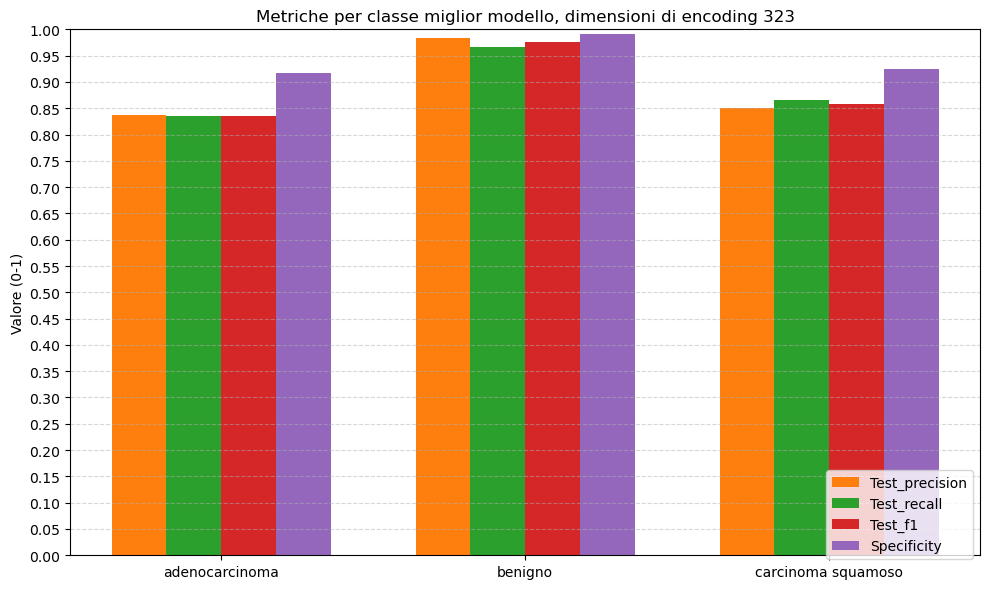

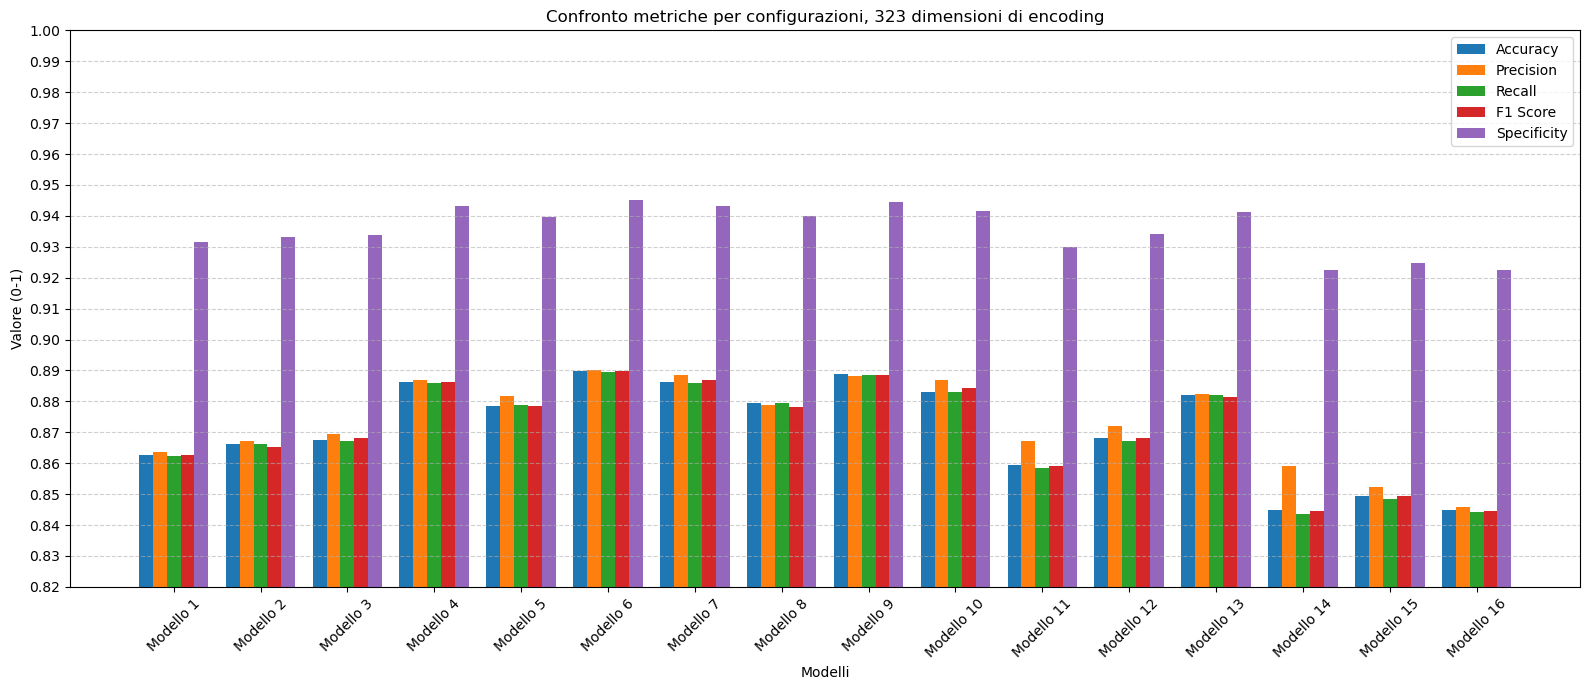

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

csv_path = "ae_outputs/ae_data_323_0.2_summary.csv"  # percorso al file CSV
config_id = 6
pretty_labels = ['adenocarcinoma', 'benigno', 'carcinoma squamoso']
output_folder = "ae_outputs"
encoding_dim = 323  # per il titolo

summary_df = pd.read_csv(csv_path)

row = summary_df[summary_df['config_id'] == config_id].iloc[0]

# estrai le metriche per classe
metrics = ['test_precision', 'test_recall', 'test_f1']
data = {m: [row[f'{m}_{cls}'] for cls in pretty_labels] for m in metrics}

# specificity per classe (converti da stringa)
spec_str = row['test_specificity_per_class']
specificity_list = [float(s) for s in spec_str.split(',')]
data['specificity'] = specificity_list

# colori Autoencoder (scuri)
ae_colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

x = np.arange(len(pretty_labels))
bar_width = 0.18

plt.figure(figsize=(10, 6))
for i, metric in enumerate(data.keys()):
    plt.bar(x + i * bar_width - 1.5 * bar_width, data[metric], width=bar_width,
            label=metric.capitalize(), color=ae_colors[i])

plt.xticks(x, pretty_labels)
plt.ylim(0.0, 1.0)
plt.ylabel("Valore (0-1)")
plt.title(f"Metriche per classe miglior modello, dimensioni di encoding {encoding_dim}")
plt.yticks(np.arange(0.0, 1.01, 0.05))
plt.legend(loc='lower right', bbox_to_anchor=(1, -0.02))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "metrics_comparison_per_class.png"))
plt.show()

# confronto tra configurazioni
metric_colors = {
    'accuracy': '#1f77b4',        # blu scuro
    'precision': '#ff7f0e',       # arancione scuro
    'recall': '#2ca02c',          # verde scuro
    'f1_score': '#d62728',        # rosso scuro
    'specificity': '#9467bd'      # viola scuro
}

x = np.arange(len(summary_df))
bar_width = 0.16

plt.figure(figsize=(16, 7))
plt.bar(x - 2 * bar_width, summary_df['test_accuracy'] / 100, width=bar_width,
        label='Accuracy', color=metric_colors['accuracy'])
plt.bar(x - 1 * bar_width, summary_df['test_precision'], width=bar_width,
        label='Precision', color=metric_colors['precision'])
plt.bar(x, summary_df['test_recall'], width=bar_width,
        label='Recall', color=metric_colors['recall'])
plt.bar(x + 1 * bar_width, summary_df['test_f1_score'], width=bar_width,
        label='F1 Score', color=metric_colors['f1_score'])
plt.bar(x + 2 * bar_width, summary_df['test_specificity'], width=bar_width,
        label='Specificity', color=metric_colors['specificity'])

plt.xlabel("Modelli")
plt.ylabel("Valore (0-1)")
plt.title(f"Confronto metriche per configurazioni, {encoding_dim} dimensioni di encoding")
plt.xticks(x, [f"Modello {cid}" for cid in summary_df['config_id']], rotation=45)
plt.ylim(0.82, 1)
plt.legend()
plt.yticks(np.arange(0.82, 1, 0.01))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "metrics_comparison.png"))
plt.show()


In [51]:
# il miglior modello è il 6